# Data download and preparation

In [ ]:
#@title Print TF version and GPU stats
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi

TensorFlow version: 2.7.0
Found GPU at: /device:GPU:0

Thu Jan 20 18:39:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    29W /  70W |    264MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                 

In [ ]:
from tensorflow.keras.datasets import cifar10
(train_X, train_y), (test_X, test_y) = cifar10.load_data()

170508288/170498071 [==============================] - 11s 0us/step


In [ ]:
#We need to make onehot vectors out of the labels
from tensorflow.keras.utils import to_categorical
train_y = to_categorical(train_y,num_classes=10)
test_y = to_categorical(test_y,num_classes=10)

In [ ]:
#@title Prepare Data Generators
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 512

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.4,
                                   brightness_range=(.5, 1.5),
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow(
                    train_X, train_y,
                    batch_size=batch_size,
                    shuffle=True)

num_classes = 10

# Flow test images in batches using val_datagen generator
test_generator = test_datagen.flow(
                    test_X, test_y,
                    batch_size=batch_size,
                    shuffle=True)

train_steps = len(train_generator)
test_steps = len(test_generator)

In [ ]:
#@title `plot_history()` definition
from matplotlib import pyplot as plt

def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(history.history['loss'], label='training')
  ax1.plot(history.history['val_loss'], label='validation')
  ax1.set_ylabel('Cross-Entropy Loss')
  ax1.set_yscale('log')
  if history.history.__contains__('lr'):
    ax1b = ax1.twinx()
    ax1b.plot(history.history['lr'], 'g-', linewidth=1)
    ax1b.set_yscale('log')
    ax1b.set_ylabel('Learning Rate', color='g')

  ax2.plot(history.history['accuracy'], label='training')
  ax2.plot(history.history['val_accuracy'], label='validation')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.legend()
  plt.show() 

# Defining AGC model

For the implementation of the adaptive gradient clipping we use this following github [repo](https://github.com/sayakpaul/Adaptive-Gradient-Clipping/blob/main/agc.py)

In [ ]:
import tensorflow as tf

def compute_norm(x, axis, keepdims):
    return tf.math.reduce_sum(x ** 2, axis=axis, keepdims=keepdims) ** 0.5

def unitwise_norm(x):
    if len(x.get_shape()) <= 1:  # Scalars and vectors
        axis = None
        keepdims = False
    elif len(x.get_shape()) in [2, 3]:  # Linear layers of shape IO or multihead linear
        axis = 0
        keepdims = True
    elif len(x.get_shape()) == 4:  # Conv kernels of shape HWIO
        axis = [0, 1, 2,]
        keepdims = True
    else:
        raise ValueError(f"Got a parameter with shape not in [1, 2, 4]! {x}")
    return compute_norm(x, axis, keepdims)


def adaptive_clip_grad(parameters, gradients, clip_factor=0.01,
                       eps=1e-3):
    new_grads = []
    for (params, grads) in zip(parameters, gradients):
        p_norm = unitwise_norm(params)
        max_norm = tf.math.maximum(p_norm, eps) * clip_factor
        grad_norm = unitwise_norm(grads)
        clipped_grad = grads * (max_norm / tf.math.maximum(grad_norm, 1e-6))
        new_grad = tf.where(grad_norm < max_norm, grads, clipped_grad)
        new_grads.append(new_grad)
    return new_grads

# Resnet 50 architecture without batchnorm

In [ ]:
"""ResNet50 model for Keras.
# Reference:
- [Deep Residual Learning for Image Recognition](
    https://arxiv.org/abs/1512.03385) (CVPR 2016 Best Paper Award)
Adapted from code contributed by BigMoyan.
"""

import os
import warnings
from tensorflow.keras import layers 
from tensorflow.keras.models import Model


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x


def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        strides: Strides for the first conv layer in the block.
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the first conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """
    filters1, filters2, filters3 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x


def ResNet50(input_shape=None,
             classes=10):
    """Instantiates the ResNet50 architecture.
    # Arguments
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 32.
            E.g. `(200, 200, 3)` would be one valid value.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    """
    
    img_input = layers.Input(shape=input_shape)

    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)

    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(classes, activation='softmax', name='fc10')(x)
    
    model = Model(img_input, x)

    return model

In [ ]:
import tensorflow as tf

class ResNet50_AGC_Model(Model):

  def __init__(self, inputshape, name, threshold=0.01):
        super(ResNet50_AGC_Model, self).__init__()
        self.threshold = threshold
        self.resnet = ResNet50(input_shape=inputshape, classes=10)

  #this bit of code is from keras API
  def train_step(self, data):
    # Unpack the data
    images, y = data

    with tf.GradientTape() as tape:
        y_pred = self.resnet(images)  # Forward pass
        # Compute the loss value
        loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

    # Compute gradients
    trainable_vars = self.resnet.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    # Update gradients
    updated_grad = adaptive_clip_grad(trainable_vars, gradients, self.threshold)
    # Update weights
    self.optimizer.apply_gradients(zip(updated_grad, trainable_vars))
    # Update metrics (includes the metric that tracks the loss)
    self.compiled_metrics.update_state(y, y_pred)
    # Return a dict mapping metric names to current value
    return {m.name: m.result() for m in self.metrics}

  def test_step(self, data):
    images, labels = data
    predictions = self.resnet(images, training=False)
    loss = self.compiled_loss(labels, predictions)
    self.compiled_metrics.update_state(labels, predictions)
    return {m.name: m.result() for m in self.metrics}

  def call(self, inputs):
    return self.resnet(inputs)

In [ ]:
from tensorflow.keras.optimizers import Adam
clipping_factor = 0.08 # As described in the base paper of this study
resnet50 = ResNet50_AGC_Model((32,32,3), threshold=0.08, name='resnet50_agc')

resnet50.compile(loss='categorical_crossentropy',
            optimizer=Adam(learning_rate=1e-3),
            metrics=['accuracy'])

Epoch 1/100
98/98 [==============================] - 53s 432ms/step - loss: 5.6743 - accuracy: 0.2312 - val_loss: 1.7454 - val_accuracy: 0.3621
Epoch 2/100
98/98 [==============================] - 37s 376ms/step - loss: 1.7640 - accuracy: 0.3524 - val_loss: 1.6878 - val_accuracy: 0.3783
Epoch 3/100
98/98 [==============================] - 37s 376ms/step - loss: 1.6675 - accuracy: 0.3925 - val_loss: 1.5332 - val_accuracy: 0.4375
Epoch 4/100
98/98 [==============================] - 37s 378ms/step - loss: 1.6040 - accuracy: 0.4172 - val_loss: 1.4615 - val_accuracy: 0.4615
Epoch 5/100
98/98 [==============================] - 37s 378ms/step - loss: 1.5699 - accuracy: 0.4310 - val_loss: 1.4767 - val_accuracy: 0.4643
Epoch 6/100
98/98 [==============================] - 37s 379ms/step - loss: 1.5265 - accuracy: 0.4507 - val_loss: 1.3493 - val_accuracy: 0.5115
Epoch 7/100
98/98 [==============================] - 37s 375ms/step - loss: 1.4954 - accuracy: 0.4621 - val_loss: 1.3284 - val_accuracy:

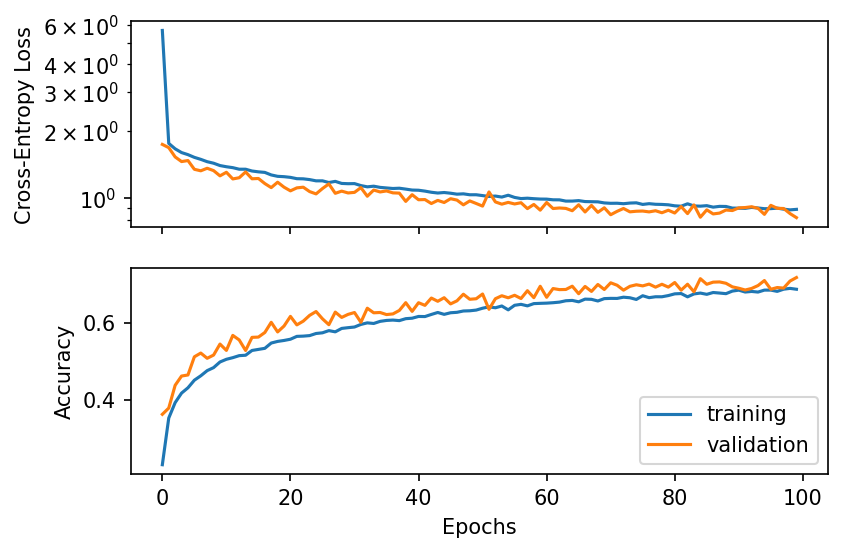

In [ ]:
history = resnet50.fit(train_generator,
                        steps_per_epoch=train_steps,# trained with 512
                        epochs=100,
                        validation_data=test_generator,
                        validation_steps=test_steps
                       )
plot_history(history)